# Pipeline
Data Preprocessing
- Grab surface smoke data from 1-10-25 00:00 UTC to 1-17-25 00:00 UTC
- Subregion data to the LA metropolitan area
- Preprocess data into 5D tensor for convlstm input
  
Training
- Pass into convlstm
- Examine results
  
Inference
- Pass a sample into the convlstm
- Examine results

# Data Preprocessing

In [12]:
from herbie import Herbie, wgrib2, paint
from herbie.toolbox import EasyMap, ccrs, pc
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import math
import cv2

In [2]:
# downloads 7 days of data (1-10 to 1-17), 24 hours (00 to 23) -> 168 hours
# not forecasts -- downloading actual hourly updated data
start_day, end_day = 10, 17
start_hour, end_hour = 0, 24
grib_files = []
for day in range(start_day, end_day):
    for hour in range(start_hour, end_hour):
        date = f"2025-01-{str(day).zfill(2)}-{str(hour).zfill(2)}"
        H = Herbie(
            date,
            model="hrrr",
            product="sfc",
        )
        H.download("MASSDEN")
        my_file = H.get_localFilePath("MASSDEN")
        grib_files.append(my_file)
n_frames = len(grib_files)

print(f"Files downloaded: {n_frames}")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 01:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 04:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 05:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 07:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 10:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

In [3]:
# validate downloads, subregion each grib file, then convert to numpy arrays
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

hrrr_subregion_np = np.empty((n_frames, 30, 26))
hrrr_subregion_xarr = [None] * n_frames
for count, file in enumerate(grib_files):
    # subregion the grib files
    idx_file = wgrib2.create_inventory_file(file)    
    subset_file = wgrib2.region(file, extent, name="la_region")

    # print progress
    if ((count + 1) % 10 == 0 or count + 1 == len(grib_files)):
        print(f"{count+1}/{len(grib_files)} files converted.")

    # store as xarray and numpy
    hrrr_xarr = xr.open_dataset(subset_file, engine="cfgrib", decode_timedelta=False)
    hrrr_subregion_xarr[count] = hrrr_xarr
    hrrr_subregion_np[count] = np.flip(hrrr_xarr.mdens.to_numpy(), axis=0)

print(hrrr_subregion_np.shape)

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_03ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_64ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_10ef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_47ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_6def9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

10/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_5aef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_60ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_78ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_2aef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_aeef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_2bef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_aeef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

20/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_34ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_d7ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_c0ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_86ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_afef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_0bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_13ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

30/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b0ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_5def9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b2ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_a7ef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_cdef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_a9ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_9aef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

40/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_6def9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_3bef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_80ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_f2ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_bbef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_adef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_08ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

50/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_d9ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_90ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b6ef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_9aef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_3cef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_44ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_e6ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

60/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_28ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b1ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_e9ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_afef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_c8ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_fbef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_0aef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

70/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_96ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_0fef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c2ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_9bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_34ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_17ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_1bef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

80/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c4ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_ddef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_f3ef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_b3ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_53ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_d3ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_d6ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

90/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_58ef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_4cef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_21ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_d5ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_1def9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_08ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_c4ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

100/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a3ef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_efef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a7ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_beef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_10ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_14ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_43ef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

110/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a4ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_f8ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_3def9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_eeef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_1cef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_82ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_63ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

120/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_95ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_5bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_fbef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_deef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_3def9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_15ef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_12ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

130/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_4def9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_8eef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_16ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_82ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_91ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_7bef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_22ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

140/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_b7ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_45ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_e3ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_faef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_0eef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_bdef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_a8ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

150/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_c7ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_35ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_18ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_b5ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_daef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_8eef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_91ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

160/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_5bef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_aaef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_3bef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_90ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_70ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file


168/168 files converted.
(168, 30, 26)


In [8]:
# interpolate and create channel axis
frames = np.empty(shape=(n_frames, 40, 40, 1))
for i, frame in enumerate(hrrr_subregion_np):
    new_frame = cv2.resize(frame, (40, 40))
    new_frame = np.reshape(new_frame, (40, 40, 1)) # (row, col, channel)
    frames[i] = new_frame

print(f"Shape of a frame: {frames.shape}")

# create samples from frames
def sliding_window_of(frames, sample_size, rows, cols, channels):
    n_samples = len(frames) - sample_size
    samples = np.empty((n_samples, sample_size, rows, cols, channels))
    for i in range(n_samples):
        samples[i] = np.array([frames[j] for j in range(i, i + sample_size)])
    return samples

complete_dataset = sliding_window_of(frames=frames, sample_size=5, rows=40, cols=40, channels=1)
print(f"Shape of the final input: {complete_dataset.shape}")

Shape of scaled frames: (168, 30, 26)
Shape of a frame: (168, 40, 40, 1)
Shape of the final input: (163, 5, 40, 40, 1)


# Training
https://keras.io/examples/vision/conv_lstm/

In [10]:
# split data into training and validation sets
split_idx = int(len(complete_dataset) * 0.75)
train_dataset, val_dataset = complete_dataset[0:split_idx], complete_dataset[split_idx:]

# standard scale data
def std_scale(data):
    mean = data.mean()
    var = data.var()
    return (data - mean) / math.sqrt(var)
    
# scale separately
train_dataset = std_scale(train_dataset)
val_dataset = std_scale(val_dataset)

# next-frame prediction: x = frames (0, n-1), y = frames (1, n)
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (122, 4, 40, 40, 1), (122, 4, 40, 40, 1)
Validation Dataset Shapes: (41, 4, 40, 40, 1), (41, 4, 40, 40, 1)


Displaying frames for example 102.


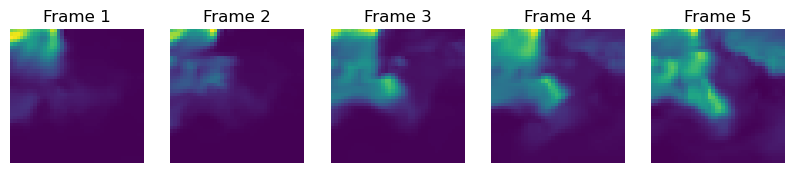

In [18]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
np.random.seed(42)
rand_sample = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[rand_sample][idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
seq = Sequential()

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            input_shape=(5, 40, 40, 1),
            padding='same', return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same', 
        data_format='channels_last'
    )
)


seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same', 
        data_format='channels_last'
    )
)

seq.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
seq.fit(x_train, y_train, batch_size=16, epochs=150)

# Inference

In [ ]:
from skimage.metrics import root_mean_squared_error as rmse

y_hat = seq.predict(x_val, verbose=0)
print("Shape of test: ", y_val.shape)

print("RESULTS")
print("---------------------------------------------------------------------------")
print("Root mean squared error: ", rmse(y_hat, y_val))
print("RMSE as % of mean: ", rmse(y_hat, y_val) / mean(y_val) * 100)
print("---------------------------------------------------------------------------")

for i in range(5):
    print("Frame " + str((i+1)) + " (Hour " + str((i+1)) + ") All Locations - Raw RMSE: ", rmse(y_hat[i, :], y_val[i, :]))
    print("Frame " + str((i+1)) + " (Hour " + str((i+1)) + ") All Locations - RMSE Percent Error of Mean: ", rmse(y_hat[i,:], y_val[i,:]) / mean(y_val[i,:]) * 100, "%\n")

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 8))

# plot original frames
np.random.seed(42)
rand_sample = np.random.choice(range(len(y_val)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(y_val[rand_sample][idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()

# plot predicted frames
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(y_hat[rand_sample][idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()